# Model: Logistic Regression

## Imports and Settings

In [1]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.evaluation import explore_thresholds
from churn_detection.visualization import churn_performance_report
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.features import (InteractionStrengthExtractor,
                                      FeatureConcatenator, 
                                      RareCategoryEncoder)
from churn_detection.paths import PARENT_DIR
from churn_detection.config import load_config
from churn_detection.models.ml_pipeline import create_pipeline
from churn_detection.models.experiment import ExperimentManager


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

In [4]:
extractor = InteractionStrengthExtractor("partner", "paymentmethod", ordinal_encode=True)
extractor.fit(preprocessed_data)

new_preprocessed_data = extractor.transform(preprocessed_data)
strength_feature = extractor.get_strength_col_name()

discrete_vars_pairs = list(combinations(categorical_variables, 2))
concat_transformer = FeatureConcatenator(feature_pairs=discrete_vars_pairs)
concat_preprocessed_data = concat_transformer.transform(new_preprocessed_data)

In [5]:
prep_train, prep_test = train_test_split(
        concat_preprocessed_data, 
        test_size=0.2, 
        random_state=1
)

X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

In [6]:
continuous_set = numeric_variables + [strength_feature]
discrete_set = categorical_variables + concat_transformer.get_new_feature_names()

## Model Configuration

In [7]:
config_dir = PARENT_DIR / "configs"
config = load_config(config_dir / "config.yaml")

In [8]:
# Feature Transforms:
num_transform_steps = [("scaler", RobustScaler(quantile_range=()))]
cat_transform_steps = [
        ("rarecat", RareCategoryEncoder(tol=0.2)),
        ("catencoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
]

config["feature_engineering"]["params"]["numerical"]["variables"] = continuous_set
config["feature_engineering"]["params"]["numerical"]["steps"] = num_transform_steps

config["feature_engineering"]["params"]["categorical"]["variables"] = discrete_set
config["feature_engineering"]["params"]["categorical"]["steps"] = cat_transform_steps

## Model Tuning and Tracking

We will treat our feature transformation choices as hyperparameters in Grid Search.

In [9]:
manager = ExperimentManager(
    create_pipeline(config), 
    experiment_name="churn_detection.lr_v9"
)

### Grid Search with Feature Engineering

In [10]:
param_grid = {
    "model__C": [100, 1000],
    "model__max_iter": [100, 200],
    "model__solver": ["saga", "liblinear"],
    "model__penalty": ["l1", "l2"],
    "feature_engineer_0__continuous__scaler__quantile_range": [(10, 90), (40, 60)],
    "feature_engineer_0__discrete__catencoder__drop": ["first", "if_binary"],
}

grid_results = manager.grid_search(
    X_train, y_train, param_grid, scoring="recall", n_jobs=-1
)

grid_results["best_params"]

2025-01-11 22:47:08,624 - experiment_manager.churn_detection.lr_v9 - INFO - Starting grid search for experiment churn_detection.lr_v9
2025-01-11 22:47:08,624 - experiment_manager.churn_detection.lr_v9 - INFO - Fitting grid search CV
2025-01-11 22:48:02,992 - experiment_manager.churn_detection.lr_v9 - INFO - Experiment saved
2025-01-11 22:48:02,993 - experiment_manager.churn_detection.lr_v9 - INFO - Grid search completed.


{'feature_engineer_0__continuous__scaler__quantile_range': (10, 90),
 'feature_engineer_0__discrete__catencoder__drop': 'first',
 'C': 1000,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear'}

## Best Model Thresholding

In [11]:
best_experiment = manager.get_best_experiment()
manager.apply_best_params(best_experiment["experiment_id"])
manager.base_pipeline.train(X_train, y_train)

In [12]:
y_probs = manager.base_pipeline.predict_proba(X_test)[:, 1]

Threshold: 0.00 - f1 Score: 0.396
Threshold: 0.02 - f1 Score: 0.434
Threshold: 0.03 - f1 Score: 0.460
Threshold: 0.05 - f1 Score: 0.484
Threshold: 0.06 - f1 Score: 0.503
Threshold: 0.08 - f1 Score: 0.514
Threshold: 0.10 - f1 Score: 0.528
Threshold: 0.11 - f1 Score: 0.542
Threshold: 0.13 - f1 Score: 0.553
Threshold: 0.14 - f1 Score: 0.562
Threshold: 0.16 - f1 Score: 0.567
Threshold: 0.17 - f1 Score: 0.576
Threshold: 0.19 - f1 Score: 0.580
Threshold: 0.21 - f1 Score: 0.582
Threshold: 0.22 - f1 Score: 0.587
Threshold: 0.24 - f1 Score: 0.592
Threshold: 0.25 - f1 Score: 0.596
Threshold: 0.27 - f1 Score: 0.604
Threshold: 0.29 - f1 Score: 0.609
Threshold: 0.30 - f1 Score: 0.611
Threshold: 0.32 - f1 Score: 0.612
Threshold: 0.33 - f1 Score: 0.610
Threshold: 0.35 - f1 Score: 0.613
Threshold: 0.37 - f1 Score: 0.611
Threshold: 0.38 - f1 Score: 0.616
Threshold: 0.40 - f1 Score: 0.613
Threshold: 0.41 - f1 Score: 0.617
Threshold: 0.43 - f1 Score: 0.619
Threshold: 0.44 - f1 Score: 0.615
Threshold: 0.4

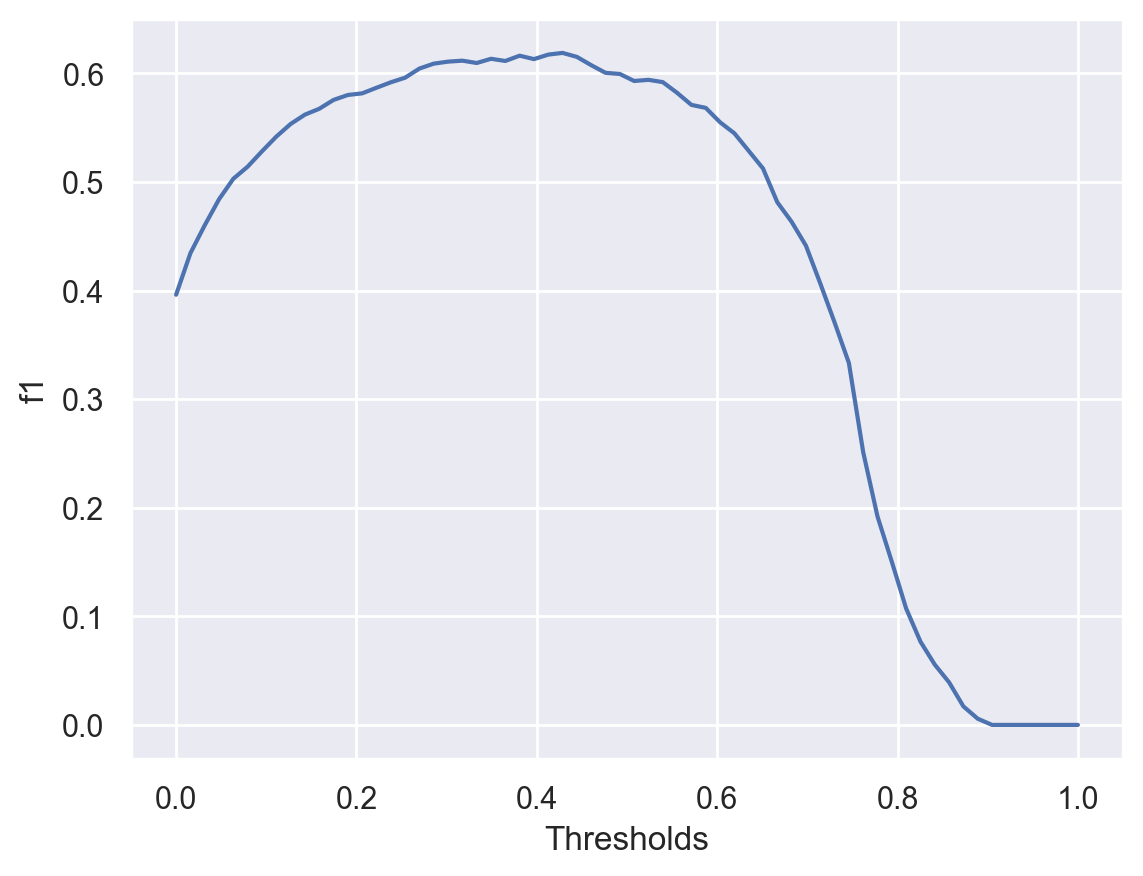

In [13]:
explore_thresholds(
    y_probs, 
    y_test, 
    func="f1", 
    n_samples=64,
    plot=True
)

In [14]:
explore_thresholds(
    y_probs, 
    y_test, 
    func="precision", 
    n_samples=64
)

Threshold: 0.00 - precision Score: 0.247
Threshold: 0.02 - precision Score: 0.278
Threshold: 0.03 - precision Score: 0.300
Threshold: 0.05 - precision Score: 0.321
Threshold: 0.06 - precision Score: 0.339
Threshold: 0.08 - precision Score: 0.350
Threshold: 0.10 - precision Score: 0.363
Threshold: 0.11 - precision Score: 0.377
Threshold: 0.13 - precision Score: 0.391
Threshold: 0.14 - precision Score: 0.402
Threshold: 0.16 - precision Score: 0.409
Threshold: 0.17 - precision Score: 0.420
Threshold: 0.19 - precision Score: 0.427
Threshold: 0.21 - precision Score: 0.432
Threshold: 0.22 - precision Score: 0.440
Threshold: 0.24 - precision Score: 0.448
Threshold: 0.25 - precision Score: 0.455
Threshold: 0.27 - precision Score: 0.467
Threshold: 0.29 - precision Score: 0.478
Threshold: 0.30 - precision Score: 0.484
Threshold: 0.32 - precision Score: 0.491
Threshold: 0.33 - precision Score: 0.497
Threshold: 0.35 - precision Score: 0.509
Threshold: 0.37 - precision Score: 0.515
Threshold: 0.38 

<br>
A good tradeoff threshold for this model seems to be 0.35

## Performance on Test Set

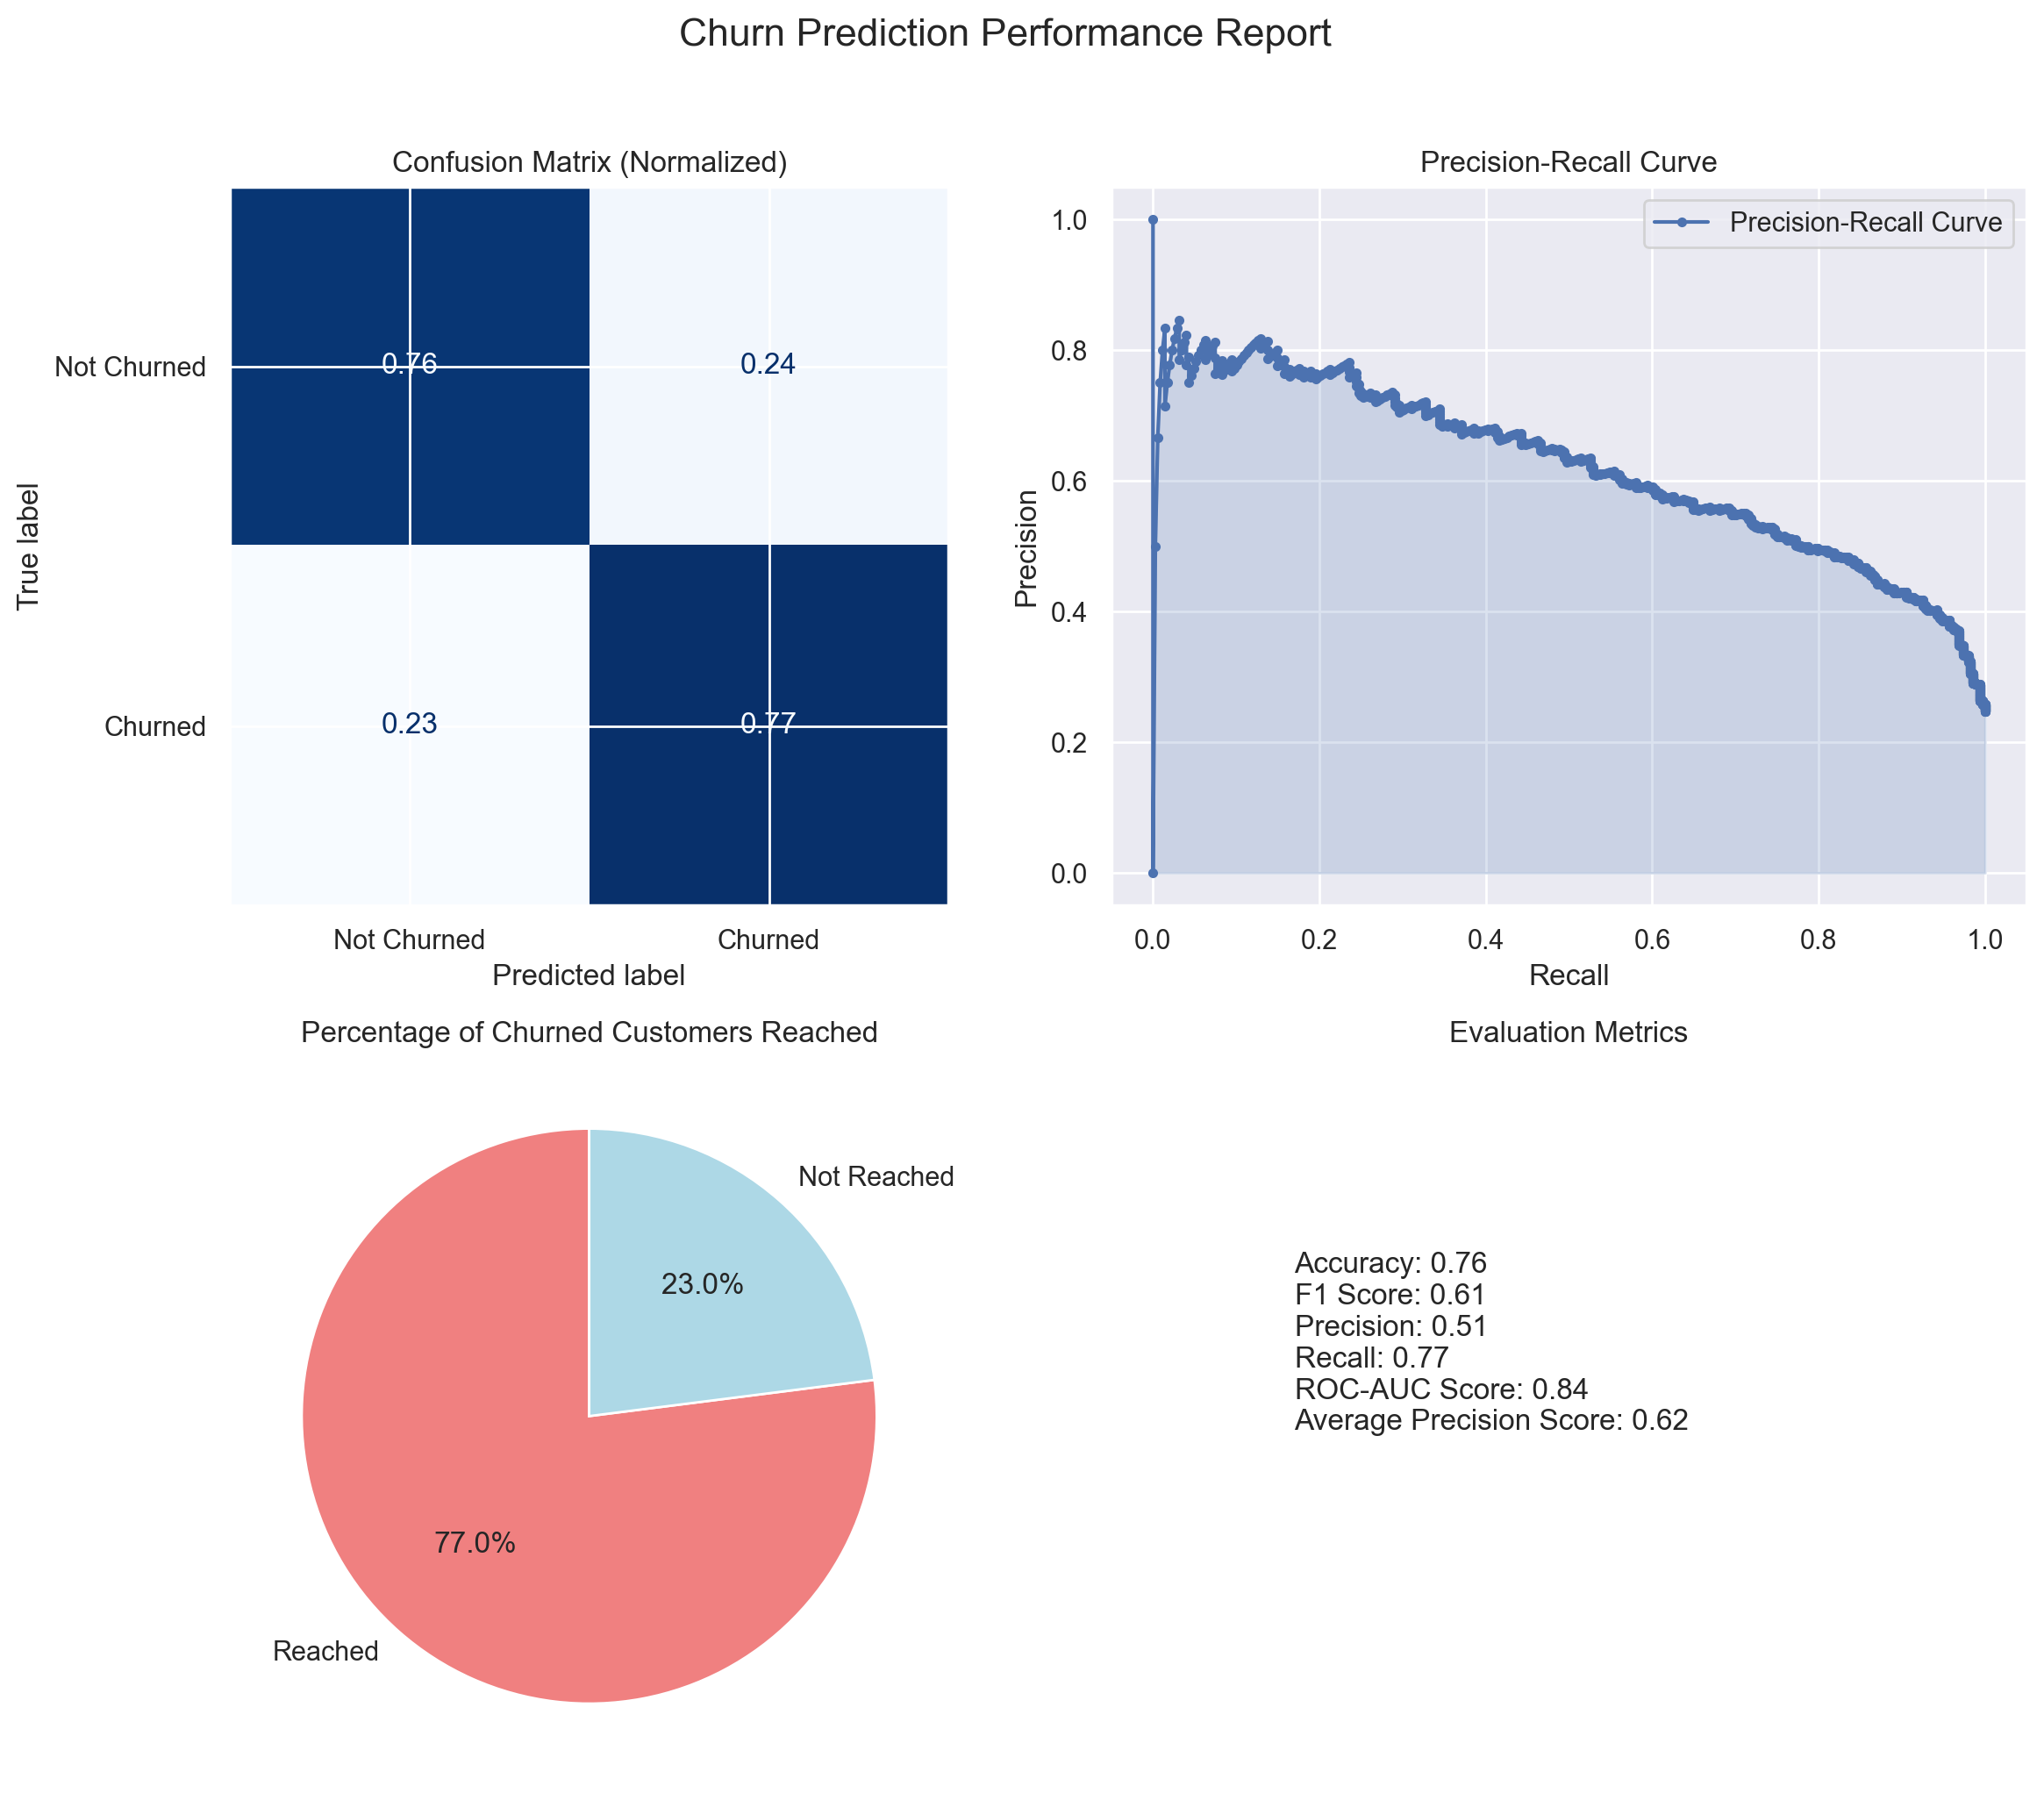

In [15]:
test_predictions = (manager.base_pipeline.predict_proba(X_test)[:, 1] >= 0.35).astype("int")
churn_performance_report(y_test, test_predictions, y_pred_proba=y_probs)

This classifier's skill is better in peformance than previous ones for reaching churned customers.